In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\moral\Dropbox\Panda\WORK\Research\FSPM\Virtual_Plant_Laboratory\Julia\VPLsite\tutorials\tree"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using VPL

module TreeTypes
    import VPL
    # Meristem
    struct Meristem <: VPL.Node end
    # Bud
    struct Bud <: VPL.Node end
    # Node
    struct Node <: VPL.Node end
    # BudNode
    struct BudNode <: VPL.Node end
    # Internode (needs to be mutable to allow for changes over time)
    Base.@kwdef mutable struct Internode <: VPL.Node
        length::Float64 = 0.15 # Internodes start at 10 cm
    end
    # Leaf
    Base.@kwdef struct Leaf <: VPL.Node
        length::Float64 = 0.15 # Leaves are 10 cm long
        width::Float64  = 0.1 # Leaves are 5 cm wide
    end    
    # Graph-level variables
    Base.@kwdef struct treeparams
        growth::Float64 = 0.1   
        budbreak::Float64 = 0.25
        phyllotaxis::Float64 = 140.0
        leaf_angle::Float64 = 30.0
        branch_angle::Float64 = 45.0
    end
end

Main.TreeTypes

In [3]:
# Create geometry + color for the internodes
function VPL.feed!(turtle::Turtle, i::TreeTypes.Internode, vars)
    # Rotate turtle around the head to implement elliptical phyllotaxis
    rh!(turtle, vars.phyllotaxis) 
    HollowCylinder!(turtle, length = i.length, height = i.length/15, width = i.length/15, 
                move = true, color = RGB(0.5,0.4,0.0))
    return nothing
end

# Create geometry + color for the leaves
function VPL.feed!(turtle::Turtle, l::TreeTypes.Leaf, vars)
    # Rotate turtle around the arm for insertion angle
    ra!(turtle, -vars.leaf_angle)
    # Generate the leaf 
    Ellipse!(turtle, length = l.length, width = l.width, move = false, 
             color = RGB(0.2,0.6,0.2))
    # Rotate turtle back to original direction
    ra!(turtle, vars.leaf_angle)
    return nothing
end

# INsertion angle for the bud nodes
function VPL.feed!(turtle::Turtle, b::TreeTypes.BudNode, vars)
    # Rotate turtle around the arm for insertion angle
    ra!(turtle, -vars.branch_angle)
end

In [4]:
meristem_rule = Rule(TreeTypes.Meristem, rhs = mer -> TreeTypes.Node() + 
                                              (TreeTypes.Bud(), TreeTypes.Leaf()) +
                                         TreeTypes.Internode() + TreeTypes.Meristem())

Rule replacing nodes of type Main.TreeTypes.Meristem without context capturing.


In [5]:
function prob_break(bud)
    # We move to parent node in the branch where the bud was created
    node =  parent(bud)
    # We count the number of internodes between node and the first Meristem 
    # moving down the graph
    check, steps = hasDescendent(node, condition = n -> data(n) isa TreeTypes.Meristem)
    steps = Int(ceil(steps/2)) # Because it will count both the nodes and the internodes
    # Compute probability of bud break and determine whether it happens
    if check
        prob =  min(1.0, steps*vars(bud).budbreak)
        return rand() < prob
    # If there is no meristem, an error happened since the model does not allow for this    
    else
        error("No meristem found in branch")
    end
end
branch_rule = Rule(TreeTypes.Bud, 
            lhs = prob_break, 
            rhs = bud -> TreeTypes.BudNode() + TreeTypes.Internode() + TreeTypes.Meristem())

Rule replacing nodes of type Main.TreeTypes.Bud without context capturing.


In [6]:
axiom = TreeTypes.Internode() + TreeTypes.Meristem()

VPL.Core.StaticGraph(Dict{Int64, Any}(2 => VPL.Core.GraphNode{Main.TreeTypes.Meristem}(Main.TreeTypes.Meristem(), Set{Int64}(), 1, 2), 1 => VPL.Core.GraphNode{Main.TreeTypes.Internode}(Main.TreeTypes.Internode(0.15), Set([2]), missing, 1)), Dict{DataType, Set{Int64}}(Main.TreeTypes.Internode => Set([1]), Main.TreeTypes.Meristem => Set([2])), 1, 2)

In [7]:
tree = Graph(axiom = axiom, rules = (meristem_rule, branch_rule), vars = TreeTypes.treeparams())

Dynamic graph with 2 nodes of types Main.TreeTypes.Internode,Main.TreeTypes.Meristem and 2 rewriting rules.
Dynamic graph variables stored in struct of type Main.TreeTypes.treeparams


In [8]:
getInternode = Query(TreeTypes.Internode)

Query object for nodes of type Main.TreeTypes.Internode


In [9]:
function elongate!(tree, query)
    for x in apply(tree, query)
        x.length = x.length*(1.0 + vars(tree).growth)
    end
end

elongate! (generic function with 1 method)

In [10]:
function growth!(tree, query)
    elongate!(tree, query)
    rewrite!(tree)
end

growth! (generic function with 1 method)

In [11]:
function simulate(tree, query, nsteps)
    new_tree = deepcopy(tree)
    for i in 1:nsteps
        growth!(new_tree, query)
    end
    return new_tree
end

simulate (generic function with 1 method)

In [12]:
newtree = simulate(tree, getInternode, 2)

Dynamic graph with 12 nodes of types Main.TreeTypes.Node,Main.TreeTypes.BudNode,Main.TreeTypes.Internode,Main.TreeTypes.Meristem,Main.TreeTypes.Leaf,Main.TreeTypes.Bud and 2 rewriting rules.
Dynamic graph variables stored in struct of type Main.TreeTypes.treeparams


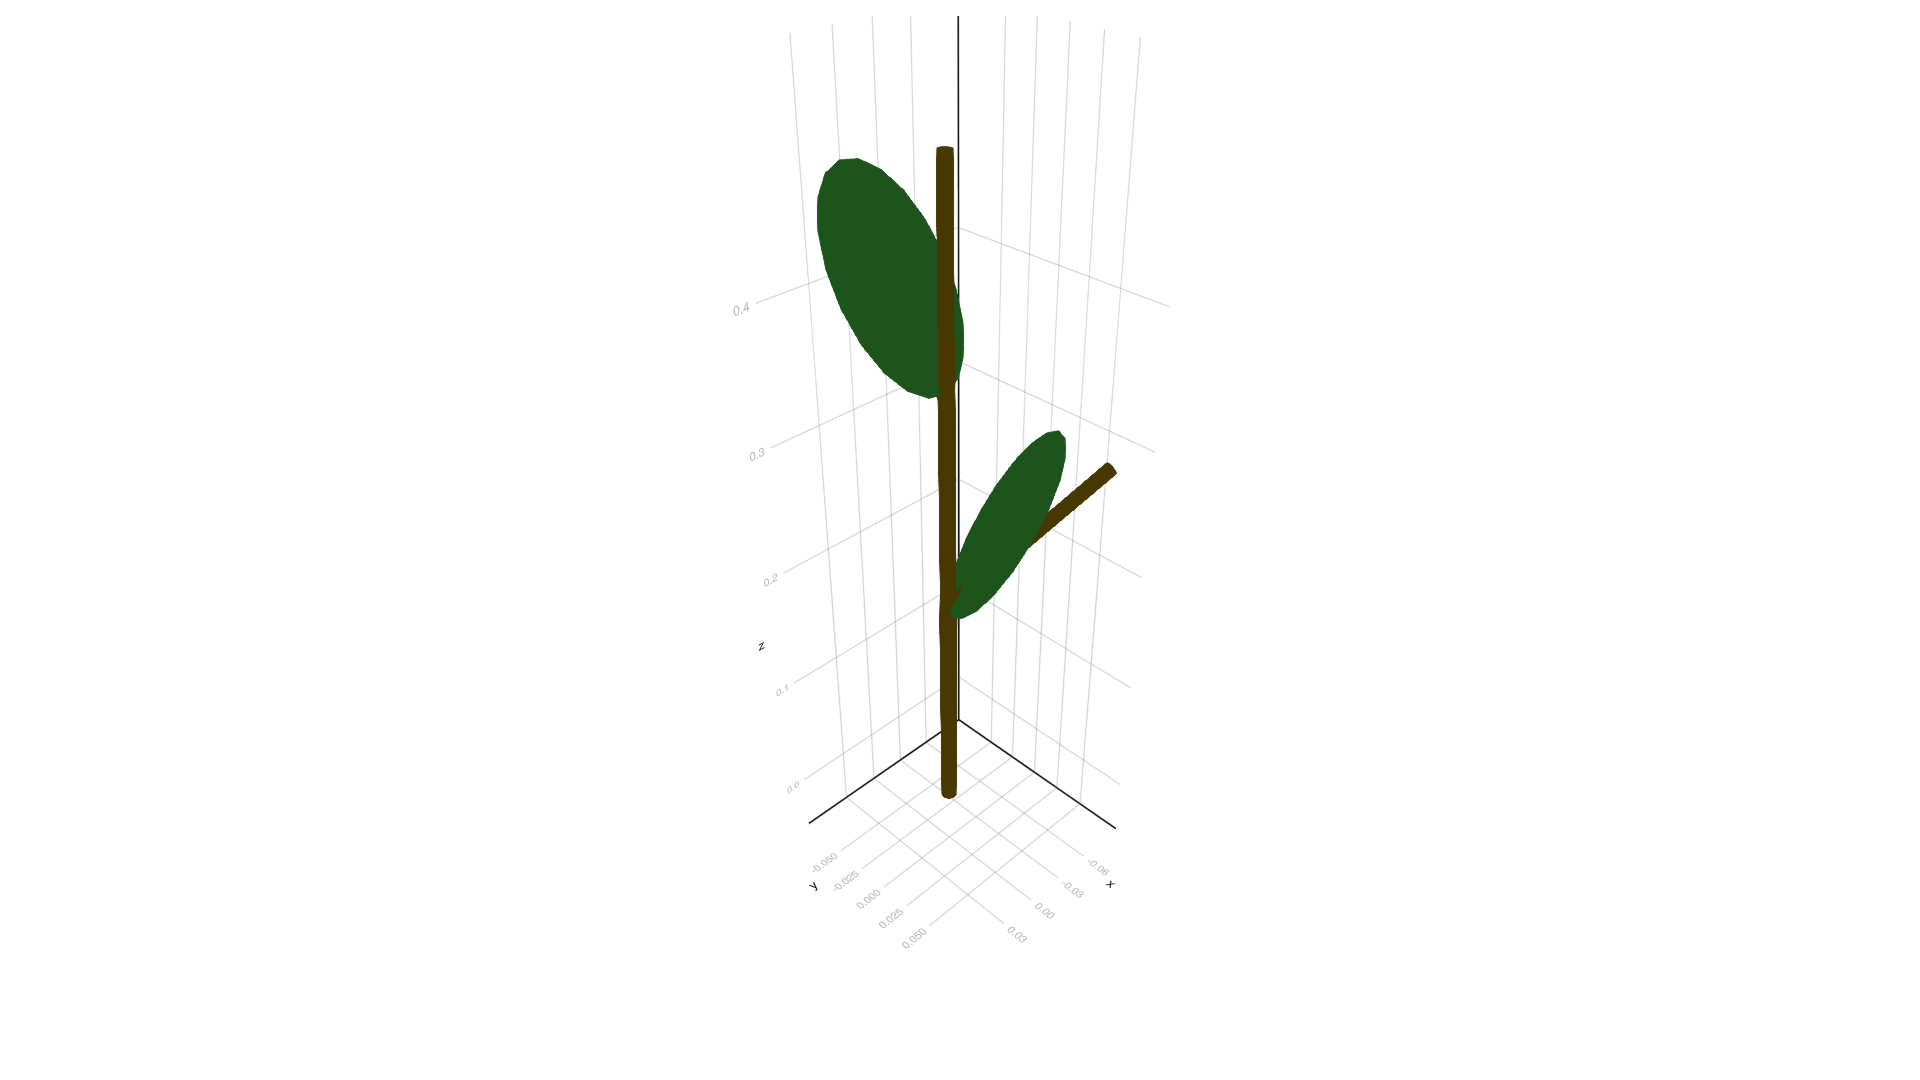

In [13]:
render(newtree)

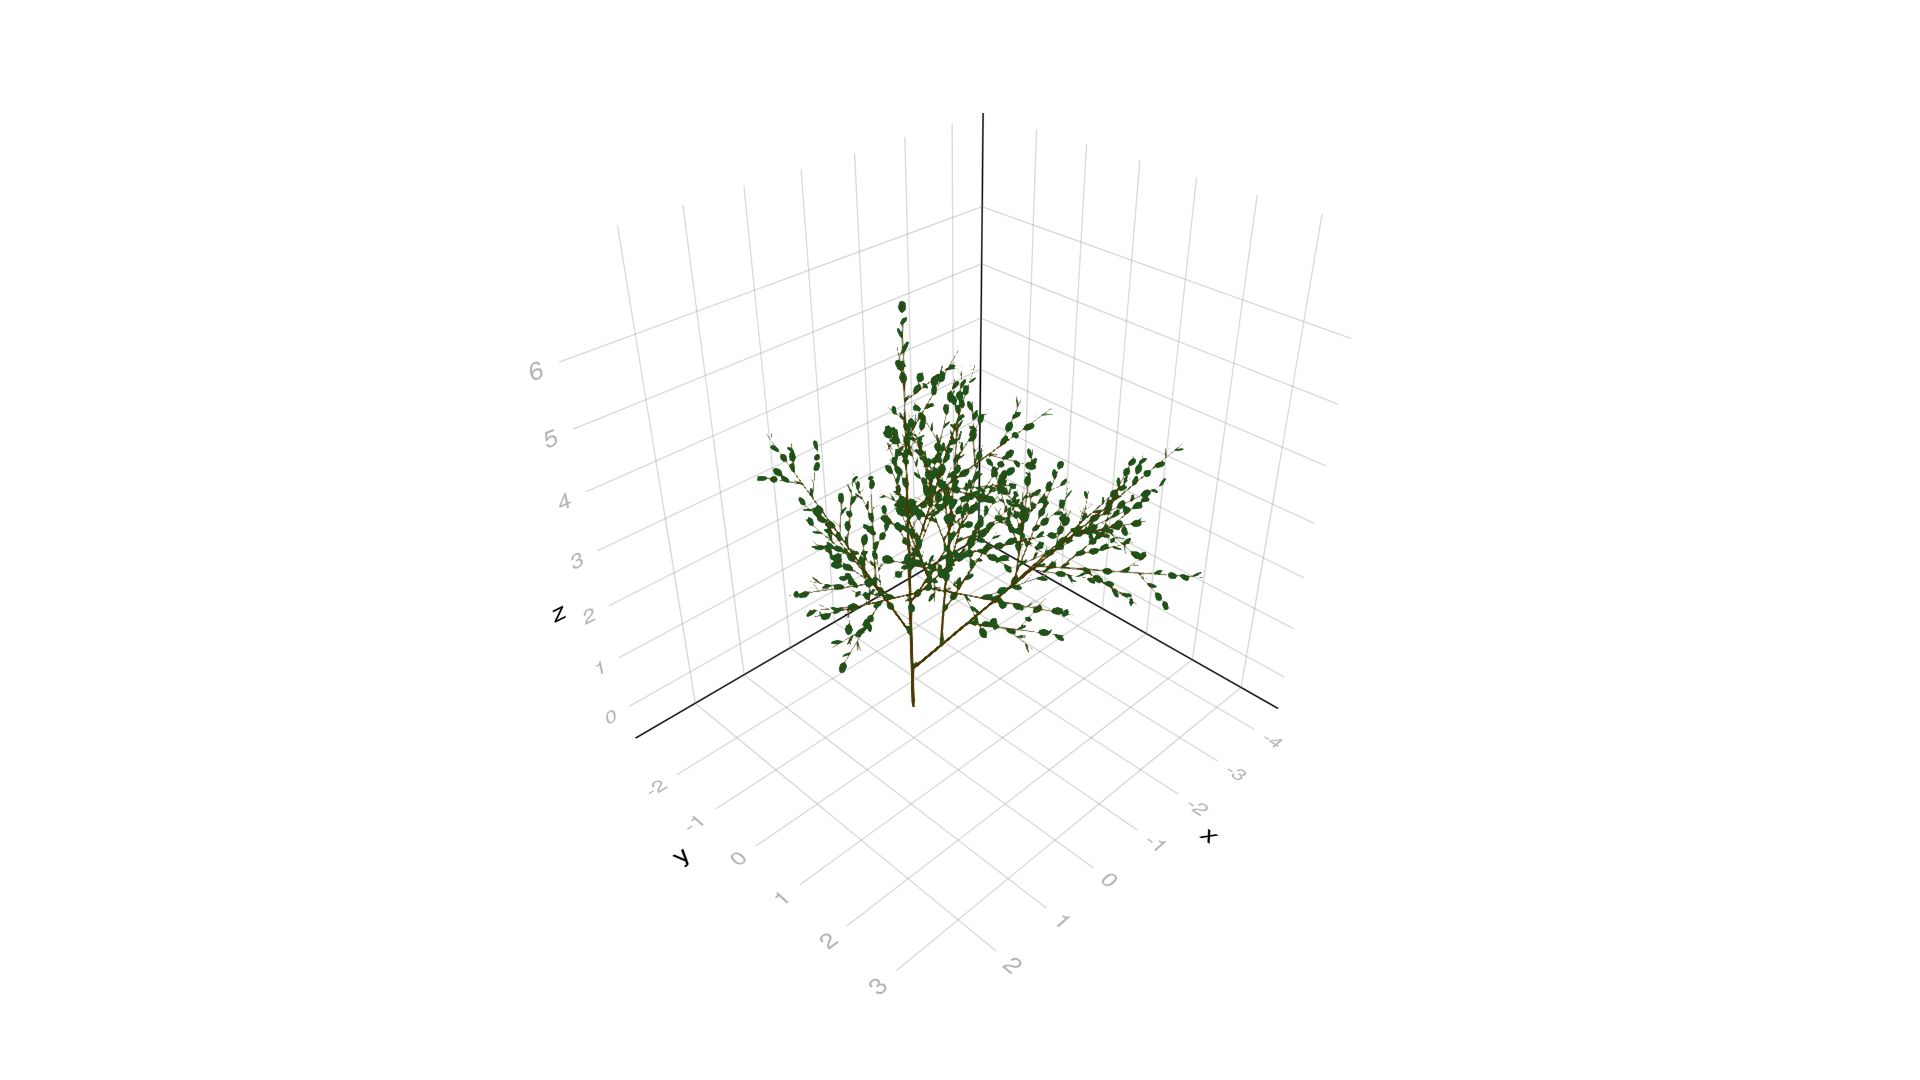

In [14]:
newtree = simulate(newtree, getInternode, 15)
render(newtree)